# 3章 犬か、猫か: Kerasのコード30行で行う転移学習

ここで紹介するコードは、原著 [Chapter 3: Cats versus Dogs: Transfer Learning in 30 Lines with Keras](https://learning.oreilly.com/library/view/practical-deep-learning/9781492034858/ch03.html) の[サンプルコード](https://github.com/PracticalDL/Practical-Deep-Learning-Book/blob/master/code/chapter-3/1-keras-custom-classifier-with-transfer-learning.ipynb) を日本語版に合わせて修正したものです。

以下のコードを実行するには、 `kaggle` コマンドもしくは手動でデータをダウンロードして、データを適切な場所に置く必要があります。
`kaggle` コマンドのインストール方法および使い方については、 Kaggle API の [GitHub リポジトリ](https://github.com/Kaggle/kaggle-api)をご覧ください。

Note: Google Colaboratory で実行する場合は、 ダウンロードしたデータを Google Drive に保存しておき、ノートブックから参照するようにすると良いでしょう。

ダウンロードしたデータ（`train.zip`）がカレントディレクトリにある場合は、以下の手順でデータを配置します

```bash
unzip train.zip
mv train data
cd data
mkdir train val
mkdir train/cat train/dog
mkdir val/cat val/dog

ls | grep cat | sort -R | head -250 | xargs -I {} mv {} train/cat/
ls | grep dog | sort -R | head -250 | xargs -I {} mv {} train/dog/
ls | grep cat | sort -R | head -250 | xargs -I {} mv {} val/cat/
ls | grep dog | sort -R | head -250 | xargs -I {} mv {} val/dog/
```

## データのパイプラインの組み立て

In [1]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Flatten, Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.applications.mobilenet import MobileNet, preprocess_input
import math

In [2]:
TRAIN_DATA_DIR = 'data/train/'
VALIDATION_DATA_DIR = 'data/val/'
TRAIN_SAMPLES = 500
VALIDATION_SAMPLES = 500
NUM_CLASSES = 2
IMG_WIDTH, IMG_HEIGHT = 224, 224
BATCH_SIZE = 64

## データの拡張

In [3]:
train_datagen = ImageDataGenerator(preprocessing_function=preprocess_input,
                                   rotation_range=20,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   zoom_range=0.2)
val_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

In [4]:
train_generator = train_datagen.flow_from_directory(
                        TRAIN_DATA_DIR,
                        target_size=(IMG_WIDTH, IMG_HEIGHT),
                        batch_size=BATCH_SIZE,
                        shuffle=True,
                        seed=12345,
                        class_mode='categorical')
validation_generator = val_datagen.flow_from_directory(
                        VALIDATION_DATA_DIR,
                        target_size=(IMG_WIDTH, IMG_HEIGHT),
                        batch_size=BATCH_SIZE,
                        shuffle=False,
                        class_mode='categorical')

Found 500 images belonging to 2 classes.
Found 500 images belonging to 2 classes.


## モデルの定義

In [5]:
def model_maker():
    base_model = MobileNet(include_top=False, input_shape = (IMG_WIDTH,IMG_HEIGHT,3))
    for layer in base_model.layers[:]:
        layer.trainable = False # 層を変更不可にします
    input = Input(shape=(IMG_WIDTH, IMG_HEIGHT, 3))
    custom_model = base_model(input)
    custom_model = GlobalAveragePooling2D()(custom_model)
    custom_model = Dense(64, activation='relu')(custom_model)
    custom_model = Dropout(0.5)(custom_model)
    predictions = Dense(NUM_CLASSES, activation='softmax')(custom_model)
    return Model(inputs=input, outputs=predictions)

## モデルの訓練

In [6]:
model = model_maker()
model.compile(loss='categorical_crossentropy',
              optimizer=tf.keras.optimizers.Adam(0.001),
              metrics=['acc'])
model.fit(train_generator,
          steps_per_epoch=math.ceil(float(TRAIN_SAMPLES) / BATCH_SIZE),
          epochs=10,
          validation_data=validation_generator,
          validation_steps=math.ceil(float(VALIDATION_SAMPLES) / BATCH_SIZE))

Epoch 1/10
8/8 [==============================] - 8s 715ms/step - loss: 0.5459 - acc: 0.7360 - val_loss: 0.1446 - val_acc: 0.9460
Epoch 2/10
8/8 [==============================] - 6s 725ms/step - loss: 0.2009 - acc: 0.9160 - val_loss: 0.0987 - val_acc: 0.9560
Epoch 3/10
8/8 [==============================] - 6s 736ms/step - loss: 0.1707 - acc: 0.9320 - val_loss: 0.0648 - val_acc: 0.9800
Epoch 4/10
8/8 [==============================] - 6s 704ms/step - loss: 0.1347 - acc: 0.9520 - val_loss: 0.0596 - val_acc: 0.9820
Epoch 5/10
8/8 [==============================] - 6s 722ms/step - loss: 0.0999 - acc: 0.9600 - val_loss: 0.0535 - val_acc: 0.9860
Epoch 6/10
8/8 [==============================] - 6s 719ms/step - loss: 0.0805 - acc: 0.9680 - val_loss: 0.0559 - val_acc: 0.9780
Epoch 7/10
8/8 [==============================] - 6s 725ms/step - loss: 0.0577 - acc: 0.9780 - val_loss: 0.0450 - val_acc: 0.9860
Epoch 8/10
8/8 [==============================] - 6s 723ms/step - loss: 0.0828 - acc: 0.97

In [7]:
model.save('model.h5')

## モデルのテスト

In [8]:
from tensorflow.keras.models import load_model


model = load_model('model.h5')

In [9]:
from tensorflow.keras.preprocessing import image
import numpy as np


img_path = 'data/dog.0.jpg'
img = image.load_img(img_path, target_size=(224,224))
img_array = image.img_to_array(img)
expanded_img_array = np.expand_dims(img_array, axis=0)
preprocessed_img = preprocess_input(expanded_img_array) # 画像への前処理を行います
prediction = model.predict(preprocessed_img)
print(prediction)
print(validation_generator.class_indices)

[[0.00761423 0.99238575]]
{'cat': 0, 'dog': 1}


https://github.com/PracticalDL/Practical-Deep-Learning-Book/blob/master/code/chapter-3/2-analyzing-the-results.ipynb

In [10]:
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

## 結果の分析

In [11]:
IMG_WIDTH, IMG_HEIGHT = 224, 224
VALIDATION_DATA_DIR = 'data/val/'
VALIDATION_BATCH_SIZE = 64

In [12]:
validation_datagen = ImageDataGenerator(
        preprocessing_function=preprocess_input)
validation_generator = validation_datagen.flow_from_directory(
        VALIDATION_DATA_DIR,
        target_size=(IMG_WIDTH, IMG_HEIGHT),
        batch_size=VALIDATION_BATCH_SIZE,
        shuffle=False,
        class_mode='categorical')
ground_truth = validation_generator.classes

Found 500 images belonging to 2 classes.


In [13]:
# ファイル名を確認
filenames = validation_generator.filenames
print('filenames')
print(len(filenames))
print(filenames[:10])
print()

ground_truth = validation_generator.classes
print('ground_truth')
print(ground_truth[:10])
print(len(ground_truth))
print()

label_to_index = validation_generator.class_indices
print('label_to_index')
print(label_to_index)
print()

index_to_label = dict((v, k) for k, v in label_to_index.items())
print('index_to_label')
print(index_to_label)

filenames
500
['cat/cat.1006.jpg', 'cat/cat.10084.jpg', 'cat/cat.10134.jpg', 'cat/cat.10136.jpg', 'cat/cat.10158.jpg', 'cat/cat.10285.jpg', 'cat/cat.10324.jpg', 'cat/cat.10349.jpg', 'cat/cat.1035.jpg', 'cat/cat.10379.jpg']

ground_truth
[0 0 0 0 0 0 0 0 0 0]
500

label_to_index
{'cat': 0, 'dog': 1}

index_to_label
{0: 'cat', 1: 'dog'}


In [14]:
predictions = model.predict(validation_generator)

In [15]:
prediction_table = {}
for index, val in enumerate(predictions):
    # argmaxを使い、予測結果のカテゴリーを取得します
    index_of_highest_probability = np.argmax(val)
    value_of_highest_probability = val[index_of_highest_probability]
    prediction_table[index] = [value_of_highest_probability, index_of_highest_probability, ground_truth[index]]

assert len(predictions) == len(ground_truth) == len(prediction_table)

In [16]:
def get_images_with_sorted_probabilities(prediction_table,
                                         get_highest_probability,
                                         label,
                                         number_of_items,
                                         only_false_predictions=False):
    sorted_prediction_table = [(k, prediction_table[k])
                               for k in sorted(prediction_table,
                                               key=prediction_table.get,
                                               reverse=get_highest_probability)
                               ]
    result = []
    for index, key in enumerate(sorted_prediction_table):
        image_index, [probability, predicted_index, gt] = key
        if predicted_index == label:
            if only_false_predictions == True:
                if predicted_index != gt:
                    result.append(
                        [image_index, [probability, predicted_index, gt]])
            else:
                result.append(
                    [image_index, [probability, predicted_index, gt]])
    return result[:number_of_items]

In [17]:
def plot_images(filenames, distances, message):
    images = []
    for filename in filenames:
        images.append(mpimg.imread(filename))
    plt.figure(figsize=(20, 15))
    columns = 5
    for i, image in enumerate(images):
        ax = plt.subplot(len(images) // columns + 1, columns, i + 1)
        ax.set_title("\n\n" + filenames[i].split("/")[-1] + "\n" +
                     "\nProbability: " +
                     str(float("{0:.2f}".format(distances[i]))))
        plt.suptitle(message, fontsize=20, fontweight='bold')
        plt.axis('off')
        plt.imshow(image)

In [18]:
def display(sorted_indices, message):
    similar_image_paths = []
    distances = []
    for name, value in sorted_indices:
        [probability, predicted_index, gt] = value
        similar_image_paths.append(VALIDATION_DATA_DIR + filenames[name])
        distances.append(probability)
    plot_images(similar_image_paths, distances, message)

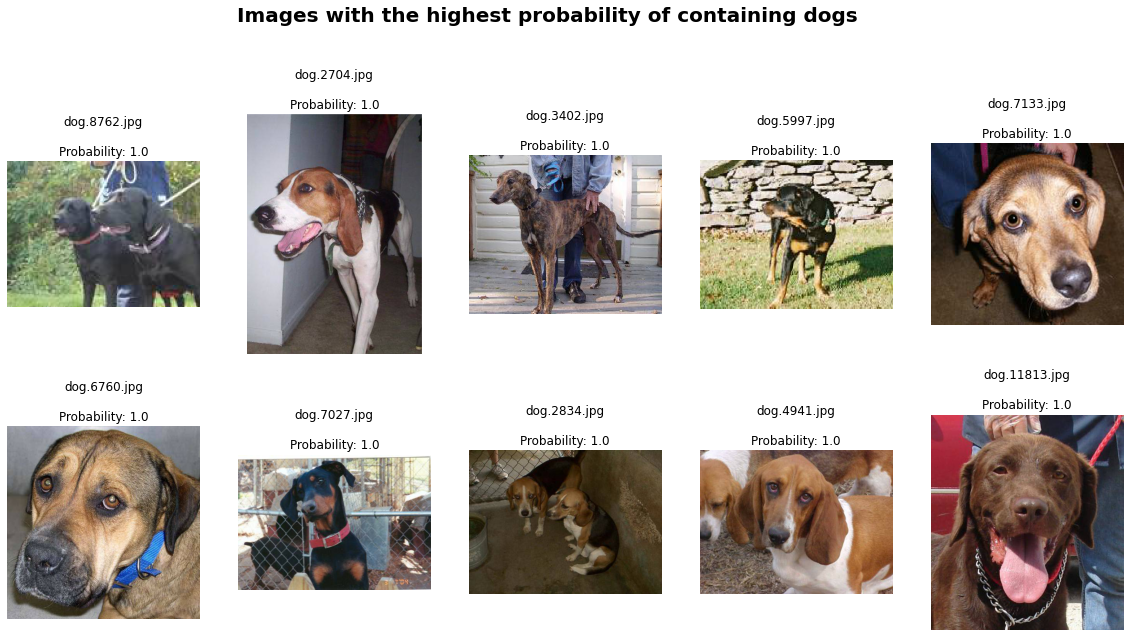

In [19]:
# 確信度の高い犬の予測
indices = get_images_with_sorted_probabilities(prediction_table,
                                               get_highest_probability=True,
                                               label=1,
                                               number_of_items=10,
                                               only_false_predictions=False)
message = 'Images with the highest probability of containing dogs'
display(indices[:10], message)

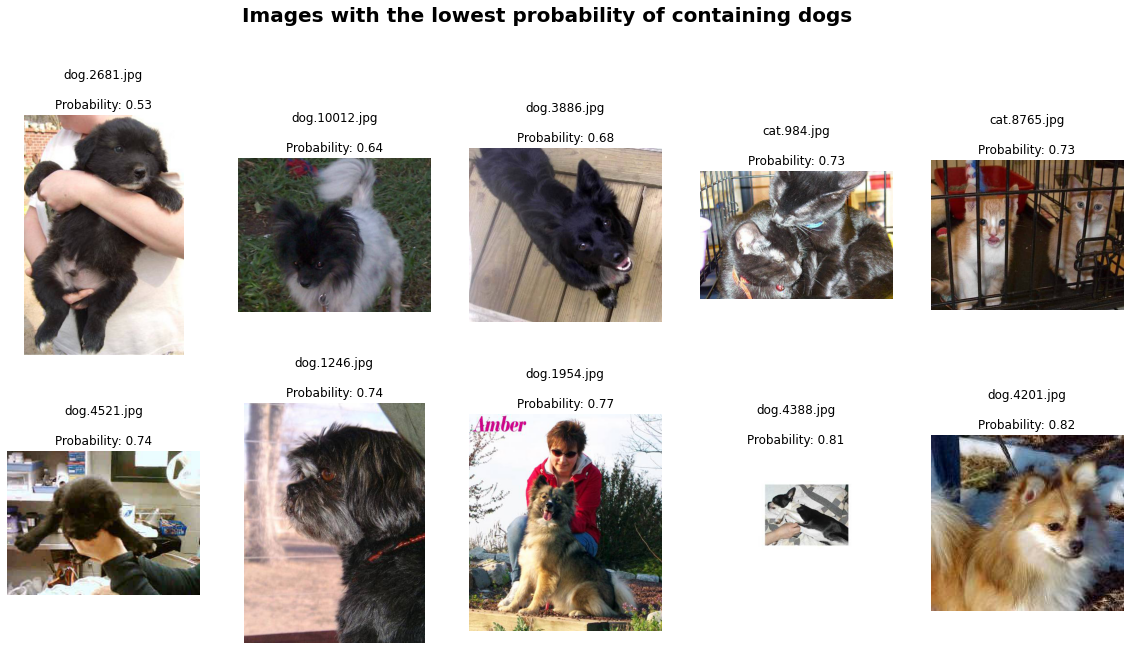

In [20]:
# 確信度の低い犬の予測
indices = get_images_with_sorted_probabilities(prediction_table,
                                               get_highest_probability=False, 
                                               label=1,
                                               number_of_items=10,
                                               only_false_predictions=False)

message = 'Images with the lowest probability of containing dogs'
display(indices[:10], message)

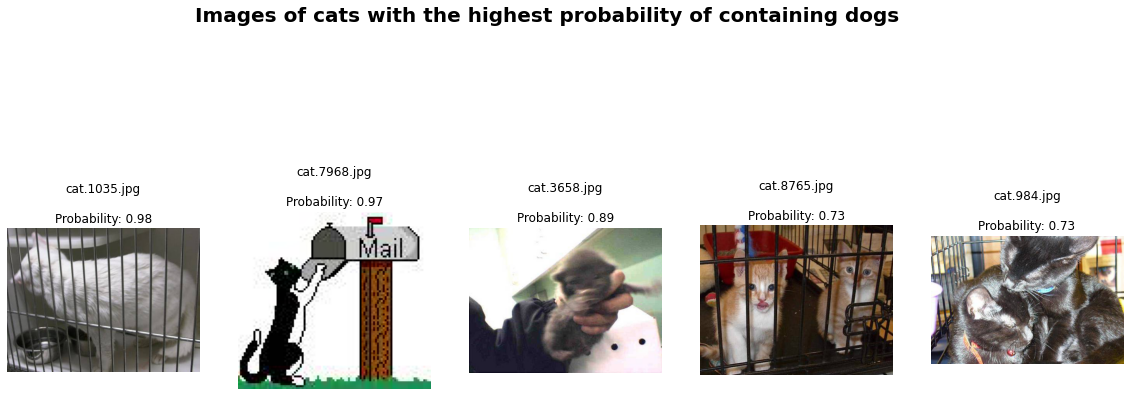

In [21]:
# 犬だという誤った予測
indices = get_images_with_sorted_probabilities(prediction_table,
                                               get_highest_probability=True,
                                               label=1,
                                               number_of_items=10,
                                               only_false_predictions=True)

message = 'Images of cats with the highest probability of containing dogs'
display(indices[:10], message)

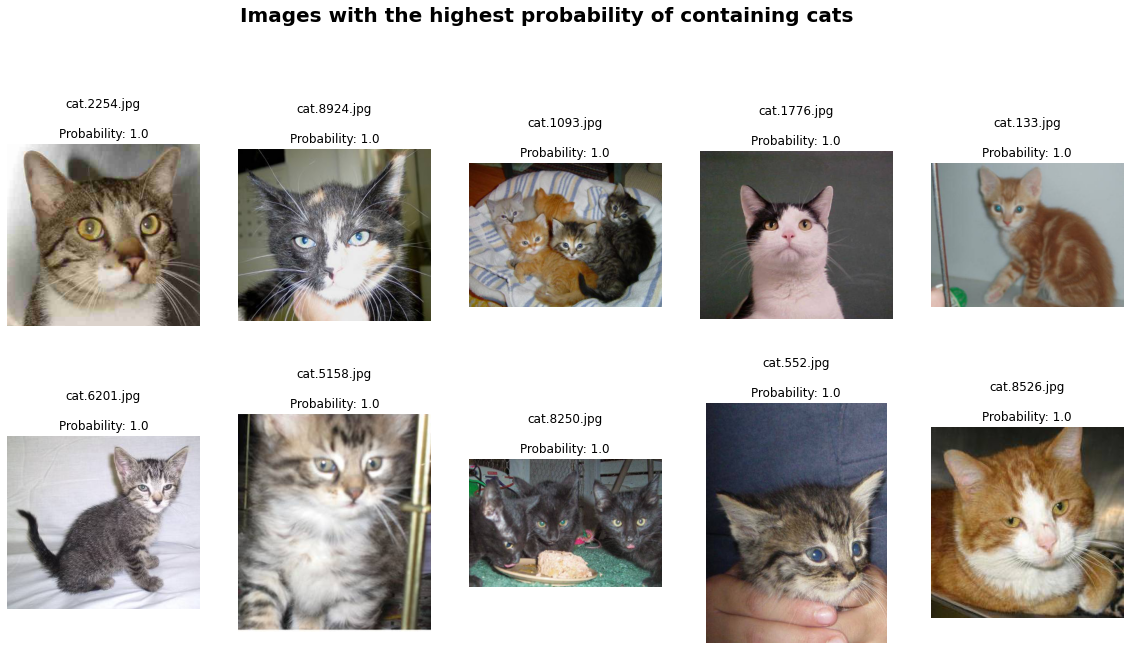

In [22]:
# 確信度の高い猫の予測
indices = get_images_with_sorted_probabilities(prediction_table, 
                                               get_highest_probability=True,
                                               label=0,
                                               number_of_items=10,
                                               only_false_predictions=False)

message = 'Images with the highest probability of containing cats'
display(indices[:10], message)

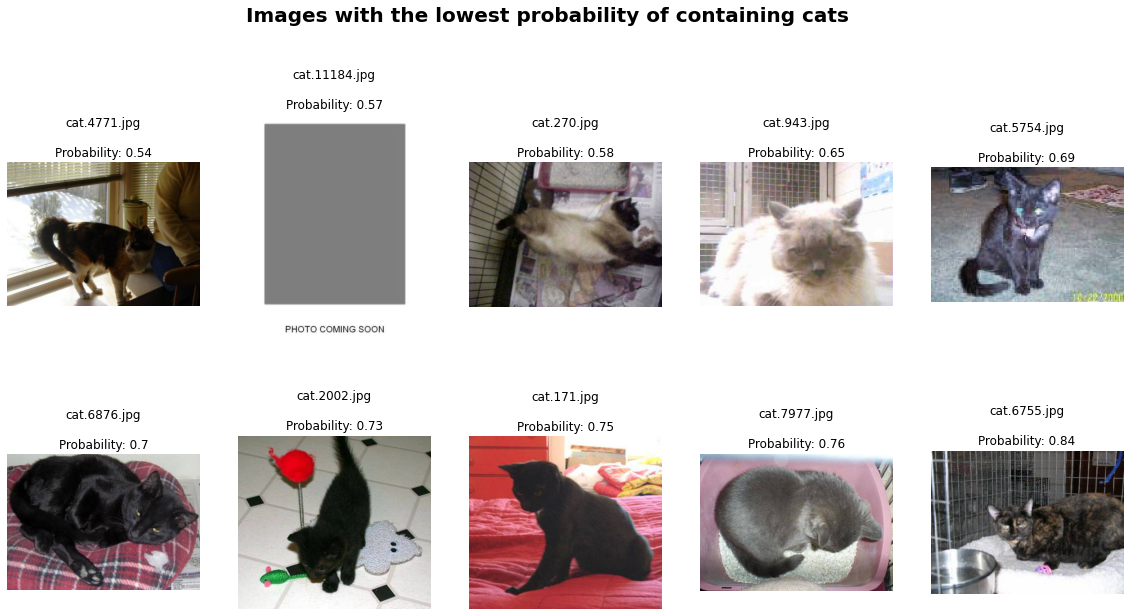

In [23]:
# 確信度の低い猫の予測
indices = get_images_with_sorted_probabilities(prediction_table,
                                               get_highest_probability=False,
                                               label=0,
                                               number_of_items=10,
                                               only_false_predictions=False)

message = 'Images with the lowest probability of containing cats'
display(indices[:10], message)

In [24]:
# 猫だという誤った予測
indices = get_images_with_sorted_probabilities(prediction_table,
                                               get_highest_probability=True,
                                               label=0,
                                               number_of_items=10,
                                               only_false_predictions=True)

message = 'Images of dogs with the highest probability of containing cats'
display(indices[:10], message)

<Figure size 1440x1080 with 0 Axes>